# Weather Data

## Retrieving and Cleaning Weather Data from August 2005 (from weather stations near each airport)

In [9]:
import pandas as pd

In [ ]:
from get_weather_data import get_katrina_weather_data as get_kat_data
from get_weather_data import clean_hourly_data

# MSY Airport, New Orleans, Ln

msy_hourly = get_kat_data('29.9893', '-90.2548', 'hourly')
msy_hourly_clean = clean_hourly_data(msy_hourly, 'MSY')


# # BTR Airport, Baton Rouge, La

btr_hourly = get_kat_data('30.53236', '-91.151461', 'hourly')
btr_hourly_clean = clean_hourly_data(btr_hourly, 'BTR')


# # GPT Airport, Biloxi, Miss

gpt_hourly = get_kat_data('30.413366', '-89.072955', 'hourly')
gpt_hourly_clean = clean_hourly_data(gpt_hourly, 'GPT')


# MOB Airport, Mobile, Ala

mob_hourly = get_kat_data('30.6882', '-88.2390', 'hourly')
mob_hourly_clean = clean_hourly_data(mob_hourly, 'MOB')


# # PNS Airport, Pensacola, Fla

pns_hourly = get_kat_data('30.473816', '-87.186705', 'hourly')
pns_hourly_clean = clean_hourly_data(pns_hourly, 'PNS')


# VPS Airport, Eglin Air Force Base, Fla

vps_hourly = get_kat_data('30.495438', '-86.549817', 'hourly')
vps_hourly_clean = clean_hourly_data(vps_hourly, 'VPS')

### Concatenating all weather data

In [12]:
df_weather_all = pd.concat([msy_hourly_clean, btr_hourly_clean, gpt_hourly_clean, mob_hourly_clean, pns_hourly_clean, vps_hourly_clean], axis=0)
df_weather_all.head()

,date,temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
0,2005-08-01 00:00:00,28.9,9.4,1015.1,MSY
1,2005-08-01 01:00:00,28.3,5.4,1015.8,MSY
2,2005-08-01 02:00:00,28.3,0.0,1016.1,MSY
3,2005-08-01 03:00:00,26.7,5.4,1016.1,MSY
4,2005-08-01 04:00:00,25.6,0.0,1016.2,MSY


### Changing date format of weather data to fit flight data

In [13]:
weather_dates=[]
for i in df_weather_all.date.tolist():
    weather_dates.append(i.split()[0])

weather_dates

df_weather_all.date = weather_dates

In [14]:
df_weather_all.head()

,date,temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
0,2005-08-01,28.9,9.4,1015.1,MSY
1,2005-08-01,28.3,5.4,1015.8,MSY
2,2005-08-01,28.3,0.0,1016.1,MSY
3,2005-08-01,26.7,5.4,1016.1,MSY
4,2005-08-01,25.6,0.0,1016.2,MSY


In [15]:
df_weather_all.describe()

,temp_celsius,wind_speed_kph,air_pressure_hPa
count,4373.000000,4373.000000,4423.000000
mean,27.777064,9.273336,1014.408478
std,3.190159,10.142043,4.538489
min,21.800000,0.000000,975.600000
25%,25.100000,3.600000,1013.800000
50%,27.200000,7.600000,1015.600000
75%,30.200000,13.000000,1016.800000
max,36.200000,111.200000,1058.400000


## Pushing weather data to SQL database for all group members to work with

In [16]:
from sql_functions import get_engine
from sql_functions import push_to_database
import psycopg2

schema = 'cgn_analytics_22_3'
engine = get_engine()
table_name = 'group_1_weather_hourly'                                                                                     

push_to_database(df=df_weather_all, table_name=table_name, engine=engine, schema=schema)

The group_1_weather_hourly table was imported successfully.


## Extract dataframe from weather table with max wind speeds per day and airport from SQL database

In [17]:
from sql_functions import get_dataframe

df_max_wind_per_day = get_dataframe(f'SELECT date, (SELECT MAX(wind_speed_kph) AS max_wind_spd), airport_code FROM {schema}.group_1_weather_hourly GROUP BY date, airport_code ORDER BY date;')

df_max_wind_per_day.head()

,date,max_wind_spd,airport_code
0,2005-08-01,16.6,MSY
1,2005-08-01,14.8,GPT
2,2005-08-01,20.5,BTR
3,2005-08-01,13.0,MOB
4,2005-08-01,13.0,VPS


## Plotting max wind speeds per day

### For every Airport

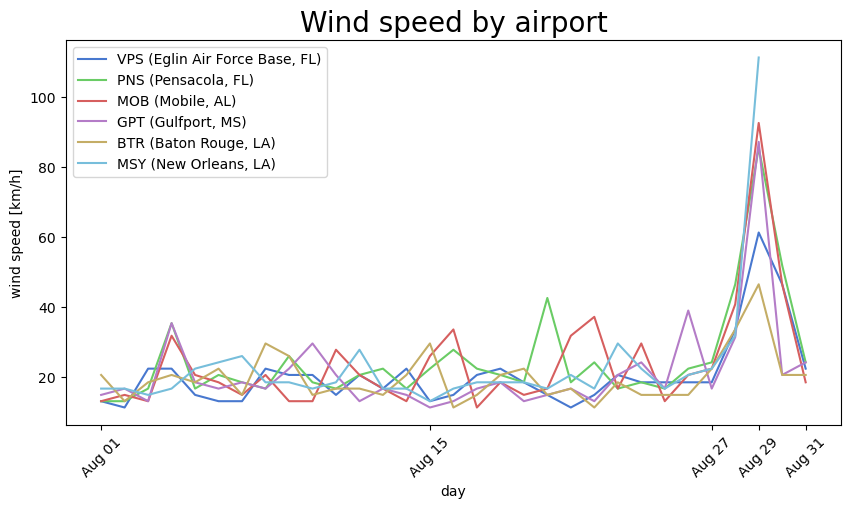

In [20]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
fig = plt.figure(figsize=(10,5))
plt.title('Wind speed by airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('wind speed [km/h]')

plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'VPS'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'VPS'], label='VPS (Eglin Air Force Base, FL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'PNS'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'PNS'], label='PNS (Pensacola, FL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MOB'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MOB'], label='MOB (Mobile, AL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'GPT'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'GPT'], label='GPT (Gulfport, MS)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'BTR'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'BTR'], label='BTR (Baton Rouge, LA)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MSY'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MSY'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

### For MSY and BTR only (highest and lowest peak wind speed)

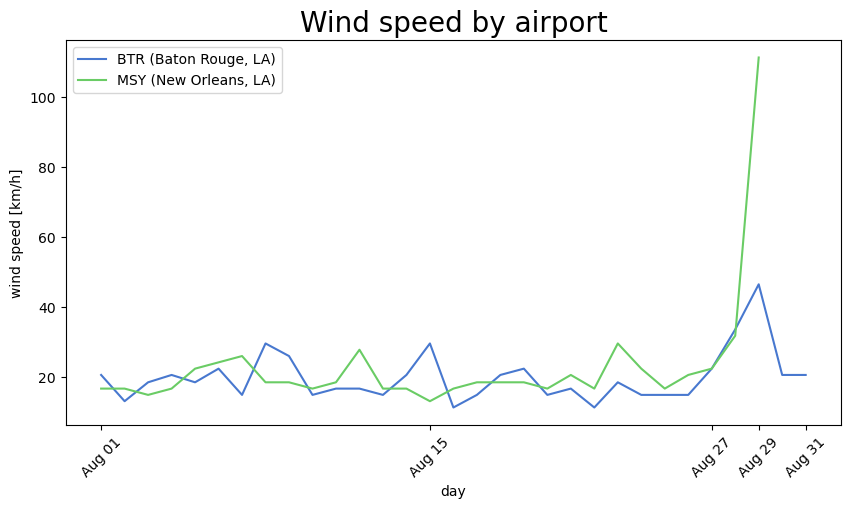

In [21]:
fig = plt.figure(figsize=(10,5))
plt.title('Wind speed by airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('wind speed [km/h]')

plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'BTR'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'BTR'], label='BTR (Baton Rouge, LA)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MSY'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MSY'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

## Plotting number of cancelled flights by origin airport (only runs in group notebook as dependant on flight data)

NameError: name 'BTR_origin_by_date' is not defined

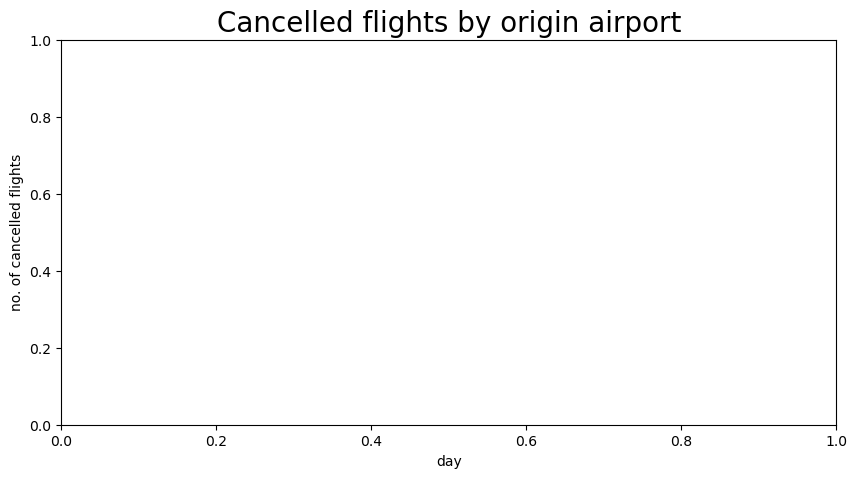

In [22]:
fig = plt.figure(figsize=(10,5))
plt.title('Cancelled flights by origin airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.plot(BTR_origin_by_date['cancelled'], label='BTR (Baton Rouge, LA)')
plt.plot(MSY_origin_by_date['cancelled'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();